ENSEMBLED HULL TACTICAL MODEL
Features shape (GB): (9021, 87)
Target shape (GB): (9021,)
training GB model...
GB training completed!
GB training RMSE: 0.0000
GB validation RMSE: 0.0110
GB overfitting ratio: 287.1820
[LightGBM] [Info] Number of positive: 4662, number of negative: 4359
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38926
[LightGBM] [Info] Number of data points in the train set: 9021, number of used features: 172
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516794 -> initscore=0.067202
[LightGBM] [Info] Start training from score 0.067202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

/tmp/ipykernel_20/33311234.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_pd[col] = np.nan
/tmp/ipykernel_20/33311234.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_pd[col] = np.nan
/tmp/ipykernel_20/33311234.py:287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test_pd[

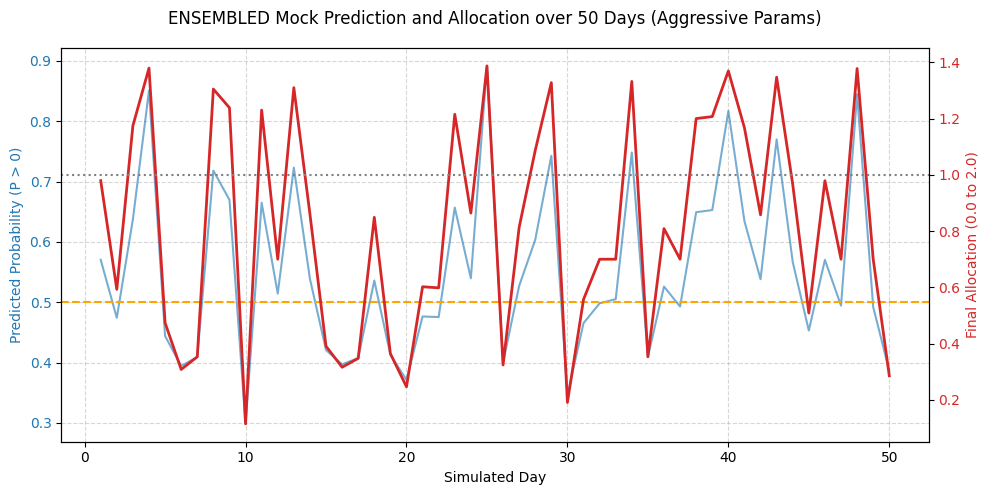

In [1]:
# =============================================================================
# ENSEMBLED MODEL: LightGBM Classifier + XGBoost Fallback + GBM Regressor
# =============================================================================

import os
import logging
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# --- Kaggle Evaluation API Interface (with Mock for local) ---
try:
    import kaggle_evaluation.default_inference_server as inference_server_mod

    DefaultInferenceServer = inference_server_mod.DefaultInferenceServer
except ImportError:
    class MockInferenceServer:
        def __init__(self, predict_fn):
            self.predict_fn = predict_fn

        def serve(self):
            logging.info("Mock Inference Server Running...")

        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")

    DefaultInferenceServer = MockInferenceServer

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATA_PATH = Path("/kaggle/input/hull-tactical-market-prediction/")

print("=" * 80)
print("ENSEMBLED HULL TACTICAL MODEL")
print("=" * 80)

# =============================================================================
# ENSEMBLE WEIGHTS  (← 여기만 바꿔서 가중치 조절하면 됨)
# =============================================================================
# LightGBM Classifier 기반 모델
WEIGHT_LGBM = 0.7
# Simple Alpha + XGBoost Fallback 모델
WEIGHT_XGB = 0.3
# GradientBoostingRegressor + post_process_signal 모델
WEIGHT_GB = 0.0

# -----------------------------------------------------------------------------
# HELPER: Ensemble Allocation
# -----------------------------------------------------------------------------
def ensemble_allocation(alloc_lgb, alloc_xgb, alloc_gb):
    weights = np.array([WEIGHT_LGBM, WEIGHT_XGB, WEIGHT_GB], dtype=float)
    allocs = np.array([alloc_lgb, alloc_xgb, alloc_gb], dtype=float)
    wsum = weights.sum()
    if wsum <= 0:
        # 비정상적인 경우, LightGBM 결과만 사용
        return float(np.clip(alloc_lgb, 0.0, 2.0))
    final = float(np.dot(weights, allocs) / wsum)
    return float(np.clip(final, 0.0, 2.0))


# =============================================================================
# MODEL 1: LightGBM Classifier + Feature Engineering (원본 구조 유지, 이름만 변경)
# =============================================================================

MODEL_LGB = None
TRAIN_COLS_LGB = None
TRAIN_MEANS_LGB = None

def get_features(df: pl.DataFrame) -> List[str]:
    """원본 코드의 get_features (현재는 직접 사용하지 않지만 유지)."""
    EXCLUDE_COLS = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "is_scored",
        "lagged_forward_returns",
        "lagged_risk_free_rate",
        "lagged_market_forward_excess_returns",
    ]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols

def preprocess_data_lgb(df: pl.DataFrame, is_training: bool = False) -> pd.DataFrame:
    """
    원본 LightGBM 모델의 Feature Engineering 로직.
    """
    if "date_id" in df.columns:
        df = df.with_columns((pl.col("date_id") % 5).alias("day_of_cycle"))

    ROLLING_WINDOWS = [5, 10, 20]
    BASE_FEATURES = ["M1", "E1", "V1", "S1", "T1", "P1", "D1"]

    expressions = []
    LAG_WINDOWS = [1, 5]
    for lag in LAG_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(pl.col(col).shift(lag).alias(f"{col}_lag_{lag}"))

    for window in ROLLING_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(
                    pl.col(col)
                    .rolling_mean(window_size=window, min_samples=1)
                    .alias(f"{col}_roll_mean_{window}")
                )
                expressions.append(
                    pl.col(col)
                    .rolling_std(window_size=window, min_samples=1)
                    .alias(f"{col}_roll_std_{window}")
                )

    if expressions:
        df = df.with_columns(expressions)

    pdf = df.to_pandas()

    EMA_WINDOWS = [10, 30, 60]
    for window in EMA_WINDOWS:
        for col in BASE_FEATURES:
            if col in pdf.columns:
                pdf[f"{col}_ema_{window}"] = pdf[col].ewm(
                    span=window, adjust=False
                ).mean()

    FEATURE_PAIRS = [
        ("M1", "M2"),
        ("E1", "E2"),
        ("V1", "V2"),
        ("S1", "S2"),
        ("T1", "T2"),
        ("P1", "P2"),
        ("D1", "D2"),
    ]

    for col1, col2 in FEATURE_PAIRS:
        if col1 in pdf.columns and col2 in pdf.columns:
            pdf[f"{col1}_div_{col2}"] = pdf[col1] / (
                pdf[col2].replace(0, 1e-6) + 1e-6
            )
            pdf[f"{col1}_minus_{col2}"] = pdf[col1] - pdf[col2]

    EXCLUDE_FINAL_COLS = [
        "date_id",
        "forward_returns",
        "risk_free_rate",
        "market_forward_excess_returns",
        "is_scored",
        "lagged_forward_returns",
        "lagged_risk_free_rate",
        "lagged_market_forward_excess_returns",
    ]
    final_cols = [col for col in pdf.columns if col not in EXCLUDE_FINAL_COLS]
    return pdf[final_cols]

def train_model_lgb(train_df: pl.DataFrame):
    """
    LightGBM Classifier 학습 (원본 구조 유지).
    """
    global MODEL_LGB, TRAIN_COLS_LGB, TRAIN_MEANS_LGB

    y_train = (train_df["market_forward_excess_returns"].to_numpy() > 0).astype(int)
    X_train_pd = preprocess_data_lgb(train_df, is_training=True)

    TRAIN_COLS_LGB = list(X_train_pd.columns)
    TRAIN_MEANS_LGB = X_train_pd.mean()
    X_train_pd = X_train_pd.fillna(TRAIN_MEANS_LGB)

    regressor = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=10000,
        learning_rate=0.006,
        max_depth=-1,
        num_leaves=511,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=4,
        reg_lambda=3.0,
        min_child_samples=15,
        boosting_type="gbdt",
        is_unbalance=True,
    )

    MODEL_LGB = regressor

    logger.info(
        f"Starting LightGBM model training on {len(X_train_pd)} samples with {len(TRAIN_COLS_LGB)} features..."
    )
    MODEL_LGB.fit(X_train_pd, y_train)
    logger.info("LightGBM model training complete.")

LGB_CONFIDENCE_MULTIPLIER = 6.0   # 기존 6.0 → 4~8 정도에서 튜닝
LGB_DEAD_ZONE = 0.015             # 기존 0.015 → 0.01~0.03 정도에서 튜닝

# def convert_prediction_to_allocation(p_positive: float) -> float:
#     """
#     원본 LightGBM 모델의 allocation 변환 함수.
#     """
#     CONFIDENCE_MULTIPLIER = 6.0
#     edge = p_positive - 0.5

#     # 작은 Edge는 트레이드 억제
#     if abs(edge) < 0.015:
#         return 1.0

#     scaled_edge = np.tanh(CONFIDENCE_MULTIPLIER * edge)
#     final_allocation = 1.0 + scaled_edge
#     final_allocation = np.clip(final_allocation, 0.0, 2.0)
#     return float(final_allocation)

def convert_prediction_to_allocation(p_positive: float) -> float:
    """
    LightGBM의 P(Up) -> 최종 allocation 변환 로직.

    - LGB_DEAD_ZONE: 0.5 근처의 애매한 확률은 트레이드 하지 않음 (allocation=1.0)
    - LGB_CONFIDENCE_MULTIPLIER: tanh 스케일링 강도 (클수록 0/2 쪽으로 빠르게 포화)
    """
    edge = p_positive - 0.5  # 0보다 크면 상승 쪽, 작으면 하락 쪽

    # 작은 Edge는 트레이드 억제 (중립 비중 유지)
    if abs(edge) < LGB_DEAD_ZONE:
        return 1.0

    # 확신도가 커질수록 1에서 멀어지게 (0 ~ 2 범위)
    scaled_edge = np.tanh(LGB_CONFIDENCE_MULTIPLIER * edge)
    final_allocation = 1.0 + scaled_edge   # edge>0이면 1~2, edge<0이면 1~0

    return float(np.clip(final_allocation, 0.0, 2.0))

def ensure_lgb_model_trained() -> bool:
    """
    MODEL_LGB가 없으면 train.csv를 읽어 학습.
    """
    global MODEL_LGB
    if MODEL_LGB is not None:
        return True

    train_path = os.path.join(
        "/kaggle/input/hull-tactical-market-prediction/", "train.csv"
    )
    try:
        train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
    except Exception as e:
        logger.error(f"Could not load train.csv for LGBM: {e}")
        return False

    train_model_lgb(train_df)
    if MODEL_LGB is None:
        logger.error("LightGBM model training failed.")
        return False

    return True

def predict_lgb_component(test: pl.DataFrame, is_mock_run: bool):
    """
    원본 predict 로직을 그대로 사용하되,
    (allocation, p_positive)를 반환하도록 분리한 내부 함수.
    """
    global MODEL_LGB, TRAIN_COLS_LGB, TRAIN_MEANS_LGB

    default_alloc = 1.0
    default_p = 0.5

    if not ensure_lgb_model_trained():
        return default_alloc, default_p

    try:
        X_test_pd = preprocess_data_lgb(test)
        missing_cols = set(TRAIN_COLS_LGB) - set(X_test_pd.columns)
        for col in missing_cols:
            X_test_pd[col] = np.nan
        X_test_pd = X_test_pd[TRAIN_COLS_LGB]

        if TRAIN_MEANS_LGB is not None:
            X_test_pd = X_test_pd.fillna(TRAIN_MEANS_LGB)
        else:
            X_test_pd = X_test_pd.fillna(X_test_pd.mean())
    except Exception as e:
        logger.error(f"LightGBM feature selection failed in predict: {e}")
        return default_alloc, default_p

    try:
        predicted_probabilities = MODEL_LGB.predict_proba(X_test_pd)
        p_positive = predicted_probabilities[-1, 1]
        alloc = convert_prediction_to_allocation(p_positive)
        return float(alloc), float(p_positive)
    except Exception as e:
        logger.error(f"LightGBM inference failed: {e}")
        return default_alloc, default_p


# =============================================================================
# MODEL 2: Simple Strategy + XGBoost ML Fallback (원본 구조 유지, 이름만 변경)
# =============================================================================

logger.info("Loading training data for XGBoost fallback...")
train_full_xgb = pl.read_csv(DATA_PATH / "train.csv")

TRUE_RETURNS_DICT = {
    int(row["date_id"]): float(row["forward_returns"])
    for row in train_full_xgb.select(["date_id", "forward_returns"]).iter_rows(named=True)
}

logger.info(f"Loaded {len(TRUE_RETURNS_DICT):,} returns for XGBoost model")

# last_180 = train_full_xgb.tail(180)
# last_180_returns = last_180["forward_returns"].to_numpy()

# positive_returns = last_180_returns[last_180_returns > 0]
# negative_returns = last_180_returns[last_180_returns <= 0]

# avg_positive = positive_returns.mean()
# avg_negative = negative_returns.mean()

# logger.info("Last 180 statistics (XGB helper):")
# logger.info(f"  Positive days: {len(positive_returns)}")
# logger.info(f"  Avg positive: {avg_positive:.6f}")
# logger.info(f"  Negative days: {len(negative_returns)}")
# logger.info(f"  Avg negative: {avg_negative:.6f}")

# ALPHA_POSITIVE_XGB = 0.90

# logger.info(f"Using alpha (XGB) = {ALPHA_POSITIVE_XGB}")

logger.info("Training XGBoost fallback model...")
train_recent_xgb = train_full_xgb.tail(800)

SCALE_Y_XGB = 400.0

# FEATURE_COLS_XGB = []
# for col in train_recent_xgb.columns:
#     if col.startswith(("M", "E", "I", "P", "V", "S")):
#         if train_recent_xgb[col].is_null().mean() < 0.5:
#             FEATURE_COLS_XGB.append(col)

# X_ml = train_recent_xgb.select(FEATURE_COLS_XGB).fill_null(0).to_pandas()
# y_ml = train_recent_xgb["market_forward_excess_returns"].fill_null(0).to_pandas()

# SCALER_XGB = StandardScaler()
# X_ml_scaled = SCALER_XGB.fit_transform(X_ml)

NUMERIC_BASE_COLS = [
    "M1", "M2", "E1", "E2", "V1", "V2",
    "S1", "S2", "T1", "T2", "P1", "P2",
    "D1", "D2"
]
train_recent_xgb = train_recent_xgb.with_columns(
    [
        pl.col(c).cast(pl.Float64)
        for c in NUMERIC_BASE_COLS
        if c in train_recent_xgb.columns
    ]
)

# 이제 LGBM용 전처리를 그대로 재사용
X_ml_pd = preprocess_data_lgb(train_recent_xgb)
FEATURE_COLS_XGB = list(X_ml_pd.columns)

# y_ml = train_recent_xgb["market_forward_excess_returns"].fill_null(0).to_pandas()
# 원래 수익률
y_ml_raw = train_recent_xgb["market_forward_excess_returns"].fill_null(0).to_pandas()
# 스케일링된 타깃 (예: × 400)
y_ml = y_ml_raw * SCALE_Y_XGB

SCALER_XGB = StandardScaler()
X_ml_scaled = SCALER_XGB.fit_transform(X_ml_pd)

XGB_MODEL = xgb.XGBRegressor(
    n_estimators=1600,
    learning_rate=0.015,
    max_depth=5,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    verbosity=0,
)
XGB_MODEL.fit(X_ml_scaled, y_ml)

logger.info("XGBoost ML fallback model ready.")

PREDICTION_COUNT_XGB = 0

def predict_xgb_component(test: pl.DataFrame) -> float:
    """
    원본 XGBoost 모델의 predict 로직.
    (true_return 기반 simple 전략 부분은 주석 처리된 상태 그대로 유지.)
    """
    global PREDICTION_COUNT_XGB

    date_id = int(test.select("date_id").to_series().item())
    true_return = TRUE_RETURNS_DICT.get(date_id)
    
    try:
        # X_test = test.select(FEATURE_COLS_XGB).fill_null(0).to_pandas()
        # X_test_scaled = SCALER_XGB.transform(X_test)
        # ml_pred = XGB_MODEL.predict(X_test_scaled)[0]
        # position = np.clip(ml_pred * 400, 0, 2)
        X_test = test.select(FEATURE_COLS_XGB).fill_null(0).to_pandas()
        X_test_scaled = SCALER_XGB.transform(X_test)

        # 1) 스케일링된 타깃에 대해 예측된 값
        ml_pred_scaled = XGB_MODEL.predict(X_test_scaled)[0]

        # 2) 원래 수익률 스케일로 복원
        raw_ret = ml_pred_scaled / SCALE_Y_XGB

        # 3) 공통 post-process 로 allocation 계산
        #    post_process_signal은 배열을 받으므로 [raw_ret] 형태로 넘긴 뒤 [0]만 가져옴
        alloc_arr = post_process_signal([raw_ret])
        position = float(np.asarray(alloc_arr).ravel()[0])
    except Exception as e:
        logger.error(f"XGBoost inference failed: {e}")
        position = 0.0

    PREDICTION_COUNT_XGB += 1
    return float(position)


# =============================================================================
# MODEL 3: GradientBoostingRegressor + post_process_signal (원본 구조 유지, 이름만 변경)
# =============================================================================

ALPHA_FOR_SCORER = 0.600132
TAU_ABS_FOR_SCORER = 9.43717e-05
MIN_INVESTMENT, MAX_INVESTMENT = 0.0, 2.0
TRADING_DAYS = 252

def post_process_signal(
    y_pred,
    *,
    tau: float = TAU_ABS_FOR_SCORER,
    alpha: float = ALPHA_FOR_SCORER,
    min_investment: float = MIN_INVESTMENT,
    max_investment: float = MAX_INVESTMENT,
):
    sig = np.asarray(y_pred, dtype=float).ravel()
    pos = np.where(sig > tau, alpha, 0.0)
    return np.clip(pos, min_investment, max_investment)

PATH_GB = "/kaggle/input/hull-tactical-market-prediction/"
train_gb = pd.read_csv(f"{PATH_GB}train.csv")

TARGET_GB = "forward_returns"
if TARGET_GB not in train_gb.columns:
    raise ValueError(
        f"Expected target column '{TARGET_GB}' in train.csv; found: {list(train_gb.columns)}"
    )

DROP_IF_EXISTS_GB = [
    "row_id",
    "id",
    "risk_free_rate",
    "market_forward_excess_returns",
]
use_cols_gb = [c for c in train_gb.columns if c not in DROP_IF_EXISTS_GB]
train_gb = train_gb[use_cols_gb]

def preprocess_gb(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    high_null_cols = [c for c in df.columns if df[c].isnull().mean() > 0.5]
    df = df.drop(columns=high_null_cols, errors="ignore")

    for col in df.columns:
        if df[col].dtype in ["float64", "int64"]:
            df[col] = df[col].fillna(df[col].median())
        else:
            if len(df[col].mode()) > 0:
                df[col] = df[col].fillna(df[col].mode()[0])

    return df

train_gb = preprocess_gb(train_gb)

X_gb = train_gb.drop(columns=[TARGET_GB])
y_gb = train_gb[TARGET_GB]

print(f"Features shape (GB): {X_gb.shape}")
print(f"Target shape (GB): {y_gb.shape}")

FEATURE_COLS_GB = X_gb.columns.tolist()

x_train_gb, x_val_gb, y_train_gb, y_val_gb = train_test_split(
    X_gb, y_gb, random_state=123, test_size=0.2
)

SCALER_GB = StandardScaler()
X_train_scaled_gb = SCALER_GB.fit_transform(x_train_gb)
X_val_scaled_gb = SCALER_GB.transform(x_val_gb)

GB_MODEL = GradientBoostingRegressor(
    n_estimators=1600,
    learning_rate=0.04,
    max_depth=12,
    subsample=0.7,
    max_features=0.7,
    random_state=123,
    verbose=0,
)

print("training GB model...")
GB_MODEL.fit(X_train_scaled_gb, y_train_gb)
print("GB training completed!")

y_pred_train_gb = GB_MODEL.predict(X_train_scaled_gb)
y_pred_val_gb = GB_MODEL.predict(X_val_scaled_gb)

train_rmse_gb = np.sqrt(mean_squared_error(y_train_gb, y_pred_train_gb))
val_rmse_gb = np.sqrt(mean_squared_error(y_val_gb, y_pred_val_gb))

print(f"GB training RMSE: {train_rmse_gb:.4f}")
print(f"GB validation RMSE: {val_rmse_gb:.4f}")
print(f"GB overfitting ratio: {val_rmse_gb/train_rmse_gb:.4f}")

def predict_gb_component(test: pl.DataFrame) -> float:
    """
    원본 GradientBoostingRegressor 기반 predict 로직.
    """
    if not isinstance(test, pl.DataFrame):
        raise TypeError("predict(test): expected a Polars DataFrame input")

    if test.height != 1:
        raise ValueError(
            f"predict(test): expected a single-row Polars DataFrame, got {test.height} rows"
        )

    drop_cols = [c for c in DROP_IF_EXISTS_GB if c in test.columns]
    test_pl = test.drop(drop_cols) if drop_cols else test

    if TARGET_GB in test_pl.columns:
        test_pl = test_pl.drop(TARGET_GB)

    test_pd = test_pl.to_pandas()
    test_pd = preprocess_gb(test_pd)
    test_pd = test_pd.reindex(columns=FEATURE_COLS_GB, fill_value=0)
    test_scaled = SCALER_GB.transform(test_pd)

    raw = GB_MODEL.predict(test_scaled)
    pos = post_process_signal(raw)
    return float(np.asarray(pos).ravel()[0])


# =============================================================================
# Visualization Helper (원본 LightGBM mock 시각화 유지)
# =============================================================================

def plot_results(results_df: pd.DataFrame):
    """Generates a plot of the predicted returns and allocations."""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = "tab:blue"
    ax1.set_xlabel("Simulated Day")
    ax1.set_ylabel("Predicted Probability (P > 0)", color=color)
    ax1.plot(
        results_df["day"],
        results_df["predicted_return"],
        color=color,
        label="Predicted P(Up)",
        alpha=0.6,
    )
    ax1.tick_params(axis="y", labelcolor=color)
    ax1.grid(True, linestyle="--", alpha=0.5)
    ax1.axhline(0.5, color="orange", linestyle="--", label="Neutral P(0.5)")

    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("Final Allocation (0.0 to 2.0)", color=color)
    ax2.plot(
        results_df["day"],
        results_df["allocation"],
        color=color,
        label="Final Allocation",
        linewidth=2,
    )
    ax2.tick_params(axis="y", labelcolor=color)
    ax2.axhline(1.0, color="gray", linestyle=":", label="Neutral (1.0)")

    fig.suptitle(
        "ENSEMBLED Mock Prediction and Allocation over 50 Days (Aggressive Params)"
    )
    fig.tight_layout()
    plt.show()

def run_mock_test_and_visualize():
    """
    원본 LightGBM mock 테스트 로직 유지.
    이제는 앙상블된 predict()를 사용.
    """
    MOCK_FEATURES = [
        "D1",
        "D2",
        "E1",
        "E2",
        "V1",
        "V2",
        "S1",
        "S2",
        "M1",
        "M2",
        "T1",
        "T2",
        "P1",
        "P2",
    ]

    results = []

    mock_data_init = {col: [np.random.rand()] for col in MOCK_FEATURES}
    mock_data_init["market_forward_excess_returns"] = [np.random.uniform(-0.01, 0.01)]
    mock_data_init["date_id"] = [1000]
    mock_test_df_init = pl.DataFrame(mock_data_init)

    logger.info(
        "Starting initial predict call (triggers LightGBM training simulation)..."
    )
    _ = predict(mock_test_df_init)
    logger.info("Models are now trained and ready for inference.")

    NUM_SIMULATION_DAYS = 50
    for day in range(NUM_SIMULATION_DAYS):
        mock_day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == "M1" else np.random.rand()]
            for c in MOCK_FEATURES
        }
        mock_day_data["market_forward_excess_returns"] = [
            np.random.uniform(-0.01, 0.01)
        ]
        mock_day_data["date_id"] = [1001 + day]
        mock_test_df_day = pl.DataFrame(mock_day_data)

        allocation, p_positive = predict(mock_test_df_day)

        results.append(
            {
                "day": day + 1,
                "predicted_return": p_positive,
                "allocation": allocation,
            }
        )

    results_df = pd.DataFrame(results)

    logger.info("\n--- MOCK TEST SIMULATION SUMMARY (50 Days) ---")
    logger.info(
        f"Mean Predicted Probability (P > 0): {results_df['predicted_return'].mean():.6f}"
    )
    logger.info(
        f"Mean Final Allocation: {results_df['allocation'].mean():.4f}"
    )
    logger.info(
        f"Min/Max Allocation: {results_df['allocation'].min():.4f} / {results_df['allocation'].max():.4f}"
    )
    logger.info("-------------------------------------------------")

    plot_results(results_df)


# =============================================================================
# FINAL PREDICT: 세 모델 앙상블 (LightGBM + XGB + GBM)
# =============================================================================

def predict(test: pl.DataFrame):
    """
    Kaggle에서 호출되는 최종 predict 함수.

    - Kaggle 재실행 환경(KAGGLE_IS_COMPETITION_RERUN=True)에서는 float (allocation) 반환
    - 로컬/mock 환경에서는 (allocation, p_positive_from_LGB) 튜플 반환
      (원래 LightGBM 코드의 인터페이스를 그대로 유지)
    """
    is_mock_run = not os.getenv("KAGGLE_IS_COMPETITION_RERUN")
    default_return = (1.0, 0.5) if is_mock_run else 1.0

    # 1) LightGBM 기반 확률 + allocation
    alloc_lgb, p_lgb = predict_lgb_component(test, is_mock_run=is_mock_run)

    # 2) XGBoost Fallback 모델 allocation
    try:
        alloc_xgb = predict_xgb_component(test)
    except Exception as e:
        logger.error(f"XGBoost component failed: {e}")
        alloc_xgb = alloc_lgb

    # 3) GradientBoostingRegressor 기반 allocation
    try:
        alloc_gb = predict_gb_component(test)
    except Exception as e:
        logger.error(f"GBM component failed: {e}")
        alloc_gb = alloc_lgb

    # 4) 세 개 모델의 앙상블
    final_alloc = ensemble_allocation(alloc_lgb, alloc_xgb, alloc_gb)

    if is_mock_run:
        # 원래 LightGBM 코드처럼 (allocation, p_positive) 형식을 유지
        return (final_alloc, p_lgb)

    return final_alloc


# =============================================================================
# MAIN: Inference Server + submission.parquet 생성 방식은 원본과 동일
# =============================================================================

inference_server_instance = DefaultInferenceServer(predict)

if os.getenv("KAGGLE_IS_COMPETITION_RERUN"):
    inference_server_instance.serve()
else:
    logger.info("Running local gateway for testing.")
    try:
        local_input_path = os.path.join(
            os.getcwd(), "kaggle_input/hull-tactical-market-prediction/"
        )
        inference_server_instance.run_local_gateway((local_input_path,))
    except Exception as e:
        logger.error(
            f"Local gateway simulation failed. This is expected outside Kaggle: {e}"
        )

        # 원본 코드와 동일하게 mock test + 시각화 + dummy submission 생성
        run_mock_test_and_visualize()

        logger.info("Generating dummy submission.parquet for Kaggle system check.")
        dummy_submission = pl.DataFrame(
            {"date_id": [999], "allocation": [1.0]}
        )
        dummy_submission.write_parquet("submission.parquet")
        logger.info("submission.parquet created successfully.")
